# Training with synthetic data when the scaling function has single argument

Here we show training with the synthetic data that mimics the viscoelastic board experiment.
One can change the magnitude of the regularization terms added to the loss function by hand.
We set it as $\lambda = 0.5$ in the following code.
This file is structured as follows:


*   Code for generating the synthetic data
*   Code for training and plotting the results

## Generating synthetic data

Here we generate synthetic data that mimic the viscoelastic board experiment.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import math
import matplotlib.pyplot as plt


# True function
def func_viscoelastic_board_experiment(x):
    Z = x[0] / ( x[1]**(1/2) * x[2] )
    return ( 2/3 * Z / ( 1 - math.exp(-Z)))


# Permutation of the order of the data to match notations in the text (just for convenience)
def perm(t):
    indices = [0, 3, 1, 2]
    transposed_tensor = t.transpose(0, 1)
    transposed_tensor = transposed_tensor[indices]
    result_tensor = transposed_tensor.transpose(0, 1)
    return result_tensor


# Generate the synthetic data (with noise)
def gen_data_one_var_synthetic(num, r=0.):
    x_data = torch.rand(num, 3)
    z_data = torch.tensor([func_viscoelastic_board_experiment(x) for x in x_data])
    kappa_data = x_data[:,0] ** 3 / (x_data[:,1] * z_data[:])
    z_data = torch.reshape(z_data, (len(z_data), 1))
    kappa_data = torch.reshape(kappa_data, (len(kappa_data), 1))
    x_data = torch.cat([x_data, kappa_data], dim=1)

    x_noise = r * torch.mul(torch.randn(x_data.size()), x_data)
    z_noise = r * torch.mul(torch.randn(z_data.size()), z_data)

    x_data += x_noise
    z_data += z_noise

    return perm(torch.log(x_data)), torch.log(z_data)

## Training module

This section prepares the necessary modules for training. The magnitude of the regularization term added to the loss function is set as $\lambda=0.5$ by hand.

In [ ]:
class NNfuncfit_one_var_synthetic(nn.Module):
    def __init__(self):
        super(NNfuncfit_one_var_synthetic, self).__init__()
        self.layer1 = nn.Linear(4, 1)
        self.layer2 = nn.Linear(1, 10)
        self.layer3 = nn.Linear(10, 10)
        self.output_layer = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.output_layer(x)
        return x


# Function that performs training once and returns the trained (normalized) parameters
def single_learning_one_var_synthetic(model, x_data, z_data, max_epoch, device):
    criterion = nn.MSELoss()
    opt = torch.optim.Adagrad(model.parameters(), lr=0.1)

    vec = torch.tensor([3, -1, -1, 0], dtype=torch.float32, device=device)

    losses = []
    losses_reg1 = []
    losses_reg2 = []

    for epoch in range(max_epoch):
        x, z = x_data.to(device), z_data.to(device)
        z = torch.reshape(z, (len(z), 1))
        y = model(x)

        # Create regularization terms (Choose the overall coefficients by hand)
        reg_term1 = 1 * (torch.norm(model.layer1.weight[0, :4])**2 - 1) ** 2
        reg_term2 = 1 * (vec @ model.layer1.weight[0, :4]) ** 2

        # Compute the loss function
        loss = criterion(y, z) + reg_term1 + reg_term2

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        losses_reg1.append(reg_term1.item())
        losses_reg2.append(reg_term2.item())

    parameters = list(model.parameters())[0].cpu().data.detach().numpy()[0]
    weights = parameters/(-parameters[3])
    normalized_weights = weights + (1 - weights[0])/3 * vec.cpu().numpy()

    print("(w)^2:", np.dot( parameters, parameters ) )
    print("(w dot vec)^2:", np.dot( parameters, vec.cpu().numpy() )**2 )

    print("final loss:", losses[-1])
    print("final reg1:", losses_reg1[-1])
    print("final reg2:", losses_reg2[-1])
    print("raw parameters:", parameters)

    plt.plot(losses, label=f'Sample')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return weights, normalized_weights


# Function that plots the training results with the training data
def plot_learned_functions(model, x_data, z_data, device, params, r):

    hor_vals = np.array([ np.dot(params, x) for x in x_data])
    z_nn = model(torch.Tensor(x_data).to(device))
    z_nn_vals = z_nn.cpu().detach().numpy()

    zip_lists = zip(hor_vals, z_data, z_nn_vals)
    zip_sort = sorted(zip_lists)
    hor_vals, z_data, z_nn_vals = zip(*zip_sort)

    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(hor_vals, z_data, label='Training data', color='cornflowerblue', marker="o", s=30)
    ax.plot(hor_vals, z_nn_vals, label='Neural network prediction', color='black', linewidth=1.5)
    ax.set_xlabel(r"$y$", size = "xx-large")
    ax.set_ylabel(r"$\psi$", labelpad=15, size = "xx-large", rotation = "horizontal")
    plt.legend(fontsize = 12, fancybox=False, edgecolor="black", borderpad=0.5, borderaxespad=0.8, handlelength=2, handletextpad=1)
    plt.tick_params(direction = "in", right=True, top=True, labelsize = 15)
    plt.tight_layout()
    fig.show()
    plt.savefig('1dim_{}.pdf'.format(r))


# Module that performs both training and plotting
def perform_single(x_data, z_data, max_epoch, r):

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = NNfuncfit_one_var_synthetic().to(device)

    weights, normalized_weights = single_learning_one_var_synthetic(model, x_data, z_data, max_epoch, device)

    print("Parameters of the first linear layer:")
    print(weights)
    print("Normalized parameters:")
    print(normalized_weights)

    print("true values")
    print([1., 0., -0.5, -1.])

    plot_learned_functions(model, x_data, z_data, device, weights, r)

## Module for the bootstrap method

In [ ]:
# Resampling of the data
def bootstrap_sample(x_data, z_data, sample_size):
    indices = np.random.choice(len(x_data), size=sample_size, replace=True)
    x_sample = x_data[indices]
    z_sample = z_data[indices]
    return x_sample, z_sample


# Function that performs training once with resampled data and returns the trained (normalized) parameters
def bootstrap_learning_one_var_experiment(model, x_data, z_data, num_samples, max_epoch, device, loss_threshold):
    parameter_samples = []
    normalized_parameter_samples = []

    vec = torch.tensor([3, -1, -1, 0], dtype=torch.float32, device=device)

    i=0

    max_error=50
    error_cnt=0

    while i < num_samples:
        if error_cnt>max_error:
          print("Too many errors.")
          break

        criterion = nn.MSELoss()
        opt = torch.optim.Adagrad(model.parameters(), lr=0.1)

        x, z = bootstrap_sample(x_data, z_data, len(x_data))
        x, z = x.to(device), z.to(device)
        z = torch.reshape(z, (len(z), 1))

        losses = []
        for epoch in range(max_epoch):
            y = model(x)

            # Create a regularization term (Choose the overall coefficients by hand)
            reg_term1 = 1 * (torch.norm(model.layer1.weight[0, :4])**2 - 1) ** 2
            reg_term2 = 1 * (vec @ model.layer1.weight[0, :4]) ** 2

            # Compute the loss function
            loss = criterion(y, z) + reg_term1 + reg_term2

            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.item())

        weights = (list(model.parameters())[0].cpu().data.detach().numpy())[0]

        if abs(losses[-1])>loss_threshold:
          print("The value of loss is too large:", losses[-1])
          print("Parameters:",weights)
          error_cnt+=1
          continue

        parameter_samples.append(weights)

        normalized_weights = weights/(-weights[3])
        normalized_weights += (1 - normalized_weights[0])/3 * vec.cpu().numpy()
        normalized_parameter_samples.append(normalized_weights)
        i+=1

    return parameter_samples, normalized_parameter_samples


# Function to calculate the standard deviation of the training results obtained by bootstrapping
def estimate_parameter_uncertainties(parameter_samples):
    parameter_samples = np.array(parameter_samples)

    np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
    print("Parameters after normalization:")
    print(parameter_samples)

    parameter_means = np.mean(parameter_samples, axis=0)
    parameter_std = np.std(parameter_samples, axis=0)
    return parameter_means, parameter_std


def to_formatted_numbers(l):
    return ["{:.4f}".format(number) for number in l]


# Module that performs both bootstrapping and error estimation
def perform_bootstrap(x_data, z_data, max_epoch, num_samples, loss_threshold):

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = NNfuncfit_one_var_synthetic().to(device)

    parameter_samples, normalized_parameter_samples = bootstrap_learning_one_var_experiment(model, x_data, z_data, num_samples, max_epoch, device, loss_threshold)
    if len(normalized_parameter_samples)>0:
      parameter_means, parameter_std = estimate_parameter_uncertainties(normalized_parameter_samples)

      print("\nParameter Means:", "   ".join(to_formatted_numbers(parameter_means)))
      print("True values    :", "   ".join(to_formatted_numbers([1., 0., -0.5, -1.])))
      print("Uncertainties    :", "   ".join(to_formatted_numbers(parameter_std)))

# Training the neural network with synthetic data

Generate synthetic data with various noise strengths and train the neural network. The uncertainty of the trained parameters is estimated by the bootstrapping method.

## r=0

(w)^2: 0.99948585
(w dot vec)^2: 1.3003820242829534e-09
final loss: 0.0003605400852393359
final reg1: 6.883965397719294e-09
final reg2: 1.3656631381309126e-09
raw parameters: [ 0.0420562   0.2975366  -0.17140408 -0.9379817 ]


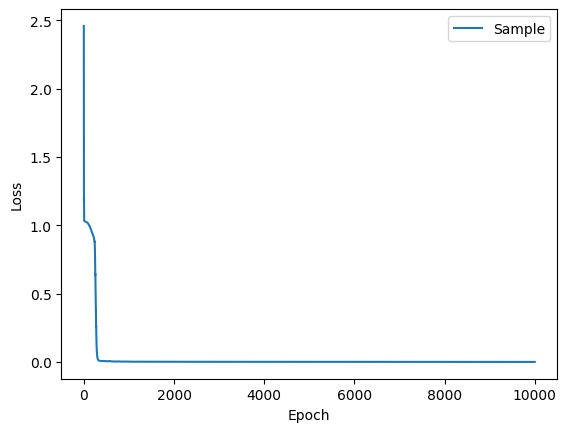

Parameters of the first linear layer:
[ 0.04483691  0.3172094  -0.18273713 -1.        ]
Normalized parameters:
[ 1.         -0.00117829 -0.5011248  -1.        ]
true values
[1.0, 0.0, -0.5, -1.0]


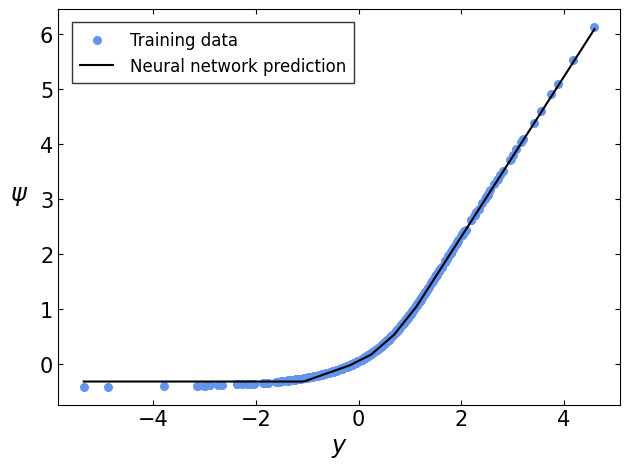

In [ ]:
num=500 # The number of the synthetic data points
x_data, z_data = gen_data_one_var_synthetic(num, r=0.) # Creation of the synthetic data. r determines the size of the noise.

max_epoch=10000
perform_single(x_data, z_data, max_epoch, 0) # The last argument 0 is just the label for the current training.

### Estimation of the uncertainity to the learned parameters by bootstrap method

In [ ]:
max_epoch=10000

num_samples=50
loss_threshold=0.5
perform_bootstrap(x_data, z_data, max_epoch, num_samples, loss_threshold)

Parameters after normalization:
[[ 1.0000 -0.0031 -0.5031 -1.0000]
 [ 1.0000 -0.0030 -0.5031 -1.0000]
 [ 1.0000 -0.0011 -0.5017 -1.0000]
 [ 1.0000 -0.0015 -0.5021 -1.0000]
 [ 1.0000 -0.0017 -0.5016 -1.0000]
 [ 1.0000 -0.0006 -0.5002 -1.0000]
 [ 1.0000 -0.0013 -0.5002 -1.0000]
 [ 1.0000 -0.0014 -0.5008 -1.0000]
 [ 1.0000 -0.0006 -0.5000 -1.0000]
 [ 1.0000 -0.0009 -0.5006 -1.0000]
 [ 1.0000 -0.0003 -0.5002 -1.0000]
 [ 1.0000  0.0001 -0.4993 -1.0000]
 [ 1.0000  0.0002 -0.4999 -1.0000]
 [ 1.0000  0.0007 -0.4998 -1.0000]
 [ 1.0000 -0.0008 -0.5008 -1.0000]
 [ 1.0000  0.0001 -0.5001 -1.0000]
 [ 1.0000  0.0002 -0.5000 -1.0000]
 [ 1.0000 -0.0005 -0.5006 -1.0000]
 [ 1.0000  0.0001 -0.4999 -1.0000]
 [ 1.0000 -0.0009 -0.5011 -1.0000]
 [ 1.0000 -0.0005 -0.5003 -1.0000]
 [ 1.0000 -0.0004 -0.5004 -1.0000]
 [ 1.0000 -0.0002 -0.5000 -1.0000]
 [ 1.0000 -0.0009 -0.5007 -1.0000]
 [ 1.0000  0.0000 -0.5000 -1.0000]
 [ 1.0000 -0.0013 -0.5011 -1.0000]
 [ 1.0000 -0.0005 -0.5003 -1.0000]
 [ 1.0000 -0.0007 -0.50

## r=0.05

In [ ]:
num=500
x_data, z_data = gen_data_one_var_synthetic(num, r=0.05)

max_epoch=10000
perform_single(x_data, z_data, max_epoch, 5) # The last argument 5 is just the label for the current training.

### Estimation of the uncertainity to the learned parameters by bootstrap method

In [ ]:
max_epoch=10000

num_samples=50
loss_threshold=0.5
perform_bootstrap(x_data, z_data, max_epoch, num_samples, loss_threshold)

## r=0.1

In [ ]:
num=500
x_data, z_data = gen_data_one_var_synthetic(num, r=0.1)

max_epoch=10000
perform_single(x_data, z_data, max_epoch, 10) # The last argument 10 is just the label for the current training.

### Estimation of the uncertainity to the learned parameters by bootstrap method

In [ ]:
max_epoch=10000

num_samples=50
loss_threshold=0.5
perform_bootstrap(x_data, z_data, max_epoch, num_samples, loss_threshold)

## r=0.15

In [ ]:
num=500
x_data, z_data = gen_data_one_var_synthetic(num, r=0.15)

max_epoch=10000
perform_single(x_data, z_data, max_epoch, 15) # The last argument 15 is just the label for the current training.

### Estimation of the uncertainity to the learned parameters by bootstrap method

In [ ]:
max_epoch=10000

num_samples=50
loss_threshold=0.5
perform_bootstrap(x_data, z_data, max_epoch, num_samples, loss_threshold)

## r=0.2

In [ ]:
num=500
x_data, z_data = gen_data_one_var_synthetic(num, r=0.2)

max_epoch=10000
perform_single(x_data, z_data, max_epoch, 20) # The last argument 20 is just the label for the current training.

### Estimation of the uncertainity to the learned parameters by bootstrap method

In [ ]:
max_epoch=10000

num_samples=50
loss_threshold=0.5
perform_bootstrap(x_data, z_data, max_epoch, num_samples, loss_threshold)

## r=0.25

In [ ]:
num=500
x_data, z_data = gen_data_one_var_synthetic(num, r=0.25)

max_epoch=10000
perform_single(x_data, z_data, max_epoch, 25) # The last argument 25 is just the label for the current training.

### Estimation of the uncertainity to the learned parameters by bootstrap method

In [ ]:
max_epoch=10000

num_samples=50
loss_threshold=0.5
perform_bootstrap(x_data, z_data, max_epoch, num_samples, loss_threshold)

# The noise dependence of the training results

Input the training results obtained above and plot the noise dependence of the parameters.

## The dependence of the results for p_1

In [ ]:
r = np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25])
p1 = np.array("Enter the list of the trained p_1's")
err1 = np.array("Enter the list of the unceratinties of the trained p_1's")

fig, ax = plt.subplots()
ax.errorbar(r, p1, yerr=err1, capsize=4, fmt='o', ecolor='black', color='cornflowerblue')
ax.set_xlabel('$r$', size = "xx-large")
ax.set_ylabel(r'$p_1$', labelpad=10, size = "xx-large", rotation = "horizontal")
plt.axhline(y=0, color ="black", linestyle =":")
plt.tick_params(direction = "in", right=True, top=True, labelsize = 15)
plt.tight_layout()
plt.savefig('1dim_p_1.pdf')
plt.show()

## The dependence of the results for p_2

In [ ]:
r = np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25])
p2 = np.array("Enter the list of the trained p_2's")
err2 = np.array("Enter the list of the unceratinties of the trained p_2's")

fig, ax = plt.subplots()
ax.errorbar(r, p2, yerr=err2, capsize=4, fmt='o', ecolor='black', color='cornflowerblue')
ax.set_xlabel('$r$', size = "xx-large")
ax.set_ylabel(r'$p_2$', labelpad=10, size = "xx-large", rotation = "horizontal")
plt.axhline(y=-0.5, color ="black", linestyle =":")
plt.tick_params(direction = "in", right=True, top=True, labelsize = 15)
plt.tight_layout()
plt.savefig('1dim_p_2.pdf')
plt.show()